## Semantic Segmentation 
- FCN with a ResNet backbone is a classic, reliable baseline that balances clarity and performance.
- Cross-Entropy with `ignore_index=255` is standard for VOC where unlabeled pixels are marked as 255.


In [1]:
# ===============================
# Setup & Imports
# ===============================
import os
import math
import random
from typing import Tuple, Dict

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
log_dir = 'runs/segmentation_experiment'
checkpoint_path = 'checkpoint.pth'
num_workers = 2 if torch.cuda.is_available() else 0
print(f"Device: {device}")


Device: cpu


In [2]:
# ===============================
# Configuration
# ===============================
config = {
    'img_size': (256, 256),
    'batch_size': 8,
    'num_classes': 21,
    'learning_rate': 1e-3,
    'ignore_index': 255,
    'use_pretrained_backbone': False,
    'checkpoint_last': 'checkpoint.pth',
    'checkpoint_best': 'checkpoint_best.pth',
}
print(config)



{'img_size': (256, 256), 'batch_size': 8, 'num_classes': 21, 'learning_rate': 0.001, 'ignore_index': 255, 'use_pretrained_backbone': False, 'checkpoint_last': 'checkpoint.pth', 'checkpoint_best': 'checkpoint_best.pth'}


### Data and Augmentations

We use Pascal VOC2012 already available in your workspace (`VOCdevkit/VOC2012`).

- Images are resized for consistent batching.
- Light augmentations are applied for regularization.
- Masks use nearest-neighbor interpolation to preserve class indices.


In [ ]:
class ToTensorMask:
    def __call__(self, sample):
        image, target = sample  # image: CHW uint8, target: HW uint8
        image = image.float() / 255.0
        return image, target.long()

class ResizePair:
    def __init__(self, size: Tuple[int, int]):
        self.size = size
    def __call__(self, sample):
        image, target = sample
        image = torch.nn.functional.interpolate(image.unsqueeze(0), size=self.size, mode='bilinear', align_corners=False).squeeze(0)
        target = torch.nn.functional.interpolate(target.unsqueeze(0).unsqueeze(0).float(), size=self.size, mode='nearest').squeeze(0).squeeze(0).long()
        return image, target

class RandomHorizontalFlipPair:
    def __init__(self, p: float = 0.5):
        self.p = p
    def __call__(self, sample):
        image, target = sample
        if random.random() < self.p:
            image = torch.flip(image, dims=[2])  # flip width
            target = torch.flip(target, dims=[1])
        return image, target

class ColorJitterOnlyImage:
    def __init__(self):
        self.tf = T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05)
    def __call__(self, sample):
        image, target = sample
        # Convert to PIL for color jitter then back to tensor [0,1]
        img_pil = T.ToPILImage()(image)
        img_pil = self.tf(img_pil)
        image = T.ToTensor()(img_pil)
        return image, target

class ComposePair:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

img_size = (256, 256)

train_joint_tf = ComposePair([
    ResizePair(img_size),
    RandomHorizontalFlipPair(p=0.5),
    ColorJitterOnlyImage(),
    ToTensorMask(),
])

val_joint_tf = ComposePair([
    ResizePair(img_size),
    ToTensorMask(),
])

def collate_fn(batch):
    images = torch.stack([b[0] for b in batch], dim=0)
    targets = torch.stack([b[1] for b in batch], dim=0)
    return images, targets

class VOCPaired(VOCSegmentation):
    def __init__(self, root, year='2012', image_set='train', download=False, joint_transform=None):
        super().__init__(root=root, year=year, image_set=image_set, download=download)
        self.joint_transform = joint_transform
    def __getitem__(self, index):
        img_path = self.images[index]
        mask_path = self.masks[index]
        # Read tensors directly (no PIL): img CHW uint8, target HW uint8
        img = torchvision.io.read_image(img_path)
        target = torchvision.io.read_image(mask_path)[0]
        if self.joint_transform is not None:
            img, target = self.joint_transform((img, target))
        return img, target

project_root = os.path.abspath('.')  # e.g., /Users/ortalhanuna/my-code
voc_expected = os.path.join(project_root, 'VOCdevkit', 'VOC2012')
if not os.path.isdir(voc_expected):
    print(f"VOC2012 not found at {voc_expected}. Will attempt download to {project_root}.")
    download_flag = True
else:
    download_flag = False

batch_size = 8
train_ds = VOCPaired(root=project_root, year='2012', image_set='train', download=download_flag, joint_transform=train_joint_tf)
val_ds = VOCPaired(root=project_root, year='2012', image_set='val', download=False, joint_transform=val_joint_tf)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train batches: 183, Val batches: 182


### Class Balance Visualization

We compute class frequency from the mask labels (ignoring label 255). This helps understand dataset bias and informs augmentation or loss re-weighting if needed.


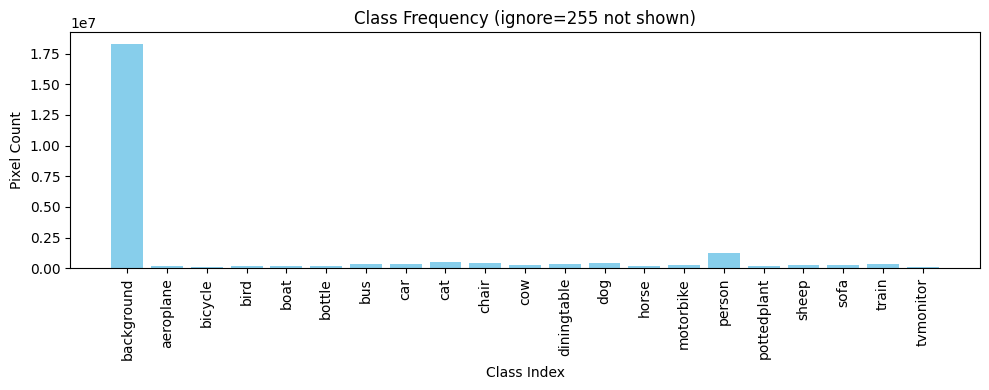

In [4]:
def compute_class_histogram(dataloader, num_classes: int = 21) -> np.ndarray:
    hist = np.zeros(num_classes, dtype=np.int64)
    for images, targets in dataloader:
        targets_np = targets.numpy()
        mask = targets_np != 255
        valid = targets_np[mask]
        binc = np.bincount(valid.flatten(), minlength=num_classes)
        hist[:len(binc)] += binc
    return hist

def plot_class_histogram(hist: np.ndarray, class_names=None):
    classes = np.arange(len(hist))
    plt.figure(figsize=(10,4))
    plt.bar(classes, hist, color='skyblue')
    plt.xlabel('Class Index')
    plt.ylabel('Pixel Count')
    plt.title('Class Frequency (ignore=255 not shown)')
    if class_names is not None and len(class_names)==len(hist):
        plt.xticks(classes, class_names, rotation=90)
    else:
        plt.xticks(classes)
    plt.tight_layout()
    plt.show()

# Compute on a subset for speed
subset_batches = min(50, len(train_loader))
hist = np.zeros(21, dtype=np.int64)
for i, (_, targets) in enumerate(train_loader):
    if i >= subset_batches:
        break
    targets_np = targets.numpy()
    mask = targets_np != 255
    valid = targets_np[mask]
    binc = np.bincount(valid.flatten(), minlength=21)
    hist += binc

voc_class_names = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]

assert len(voc_class_names) == 21

plot_class_histogram(hist, class_names=voc_class_names)







### Model: Simple FCN with ResNet18 Backbone

Rationale:
- FCN-style decoder is simple and interpretable.
- ResNet18 provides a lightweight yet expressive encoder.
- We upsample logits back to input resolution using bilinear interpolation (no transposed convolutions).
- The decoder is a small head: 3x3 conv (512→256), ReLU, then 1x1 conv to class logits.


In [5]:
import torchvision.models as models

class SimpleFCN(nn.Module):
    def __init__(self, num_classes: int = 21):
        super().__init__()
        backbone = models.resnet18(weights=None)
        self.encoder = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4,
        )
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1),
        )

    def forward(self, x):
        h, w = x.shape[-2:]
        feats = self.encoder(x)
        logits = self.classifier(feats)
        logits = torch.nn.functional.interpolate(logits, size=(h, w), mode='bilinear', align_corners=False)
        return logits

num_classes = 21
model = SimpleFCN(num_classes=num_classes).to(device)
print(f"Model params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")


Model params: 12.36M


### Loss, Optimizer, and Checkpointing

Choice of loss:
- We use `CrossEntropyLoss(ignore_index=255)` which is standard for per-pixel classification with VOC masks.
- Ignore index ensures unlabeled pixels do not affect gradients.

Optimizer:
- Adam with a moderate learning rate is a robust default for baselines.


In [6]:
writer = SummaryWriter(log_dir)


def compute_class_weights(loader, num_classes=21, ignore_index=255):
    counts = torch.zeros(num_classes)
    for _, m in loader:
        m = m.view(-1)
        m = m[(m>=0) & (m<num_classes)]
        counts += torch.bincount(m, minlength=num_classes).float()
    freq = counts / counts.sum().clamp_min(1)
    weights = 1.0 / (freq + 1e-6)
    weights = (weights / weights.mean()).clamp(max=10.0)
    return weights

class_weights = compute_class_weights(train_loader).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


def save_checkpoint(model, optimizer, epoch, path=checkpoint_path):
    torch.save({
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch
    }, path)
    print(f"Checkpoint saved at epoch {epoch}")


def load_checkpoint(model, optimizer=None, path=checkpoint_path):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint.get('model_state', checkpoint), strict=False)
        if optimizer is not None and 'optimizer_state' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state'])
        start_epoch = int(checkpoint.get('epoch', 0)) + 1
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
        return start_epoch
    return 0

start_epoch = load_checkpoint(model, optimizer)


In [7]:
def get_logits_from_model(model, images):
    out = model(images)
    if isinstance(out, dict):
        return out['out']
    return out



### Validation, Inference and Metrics

We track pixel accuracy and mean IoU (mIoU). Predictions are `argmax` over class logits. TensorBoard logs include scalar metrics and example images.


In [8]:
def compute_pixel_accuracy(preds: torch.Tensor, targets: torch.Tensor) -> float:
    mask = targets != 255
    correct = (preds[mask] == targets[mask]).sum().item()
    total = mask.sum().item()
    return correct / max(total, 1)


def compute_confusion_matrix(preds: torch.Tensor, targets: torch.Tensor, num_classes: int) -> np.ndarray:
    mask = targets != 255
    preds = preds[mask].view(-1).cpu().numpy()
    targets = targets[mask].view(-1).cpu().numpy()
    cm = np.bincount(num_classes * targets + preds, minlength=num_classes**2)
    return cm.reshape(num_classes, num_classes)


def compute_mIoU_from_cm(conf_matrix: np.ndarray) -> float:
    intersection = np.diag(conf_matrix)
    ground_truth_set = conf_matrix.sum(axis=1)
    predicted_set = conf_matrix.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    iou = intersection / np.maximum(union, 1)
    valid = ground_truth_set > 0
    return float(np.mean(iou[valid]))


def validate(model, loader, criterion, num_classes=21):
    model.eval()
    val_loss = 0.0
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)
            logits = get_logits_from_model(model, images)
            loss = criterion(logits, targets)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            conf_matrix += compute_confusion_matrix(preds, targets, num_classes)
    val_loss /= max(len(loader), 1)
    miou = compute_mIoU_from_cm(conf_matrix)
    pixel_acc = np.diag(conf_matrix).sum() / max(conf_matrix.sum(), 1)
    return val_loss, pixel_acc, miou


def inference(model, images):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        logits = get_logits_from_model(model, images)
        preds = torch.argmax(logits, dim=1)
    return preds, logits


### Visualization: Image vs. Ground Truth vs. Prediction

We overlay predictions and ground truth masks for sanity checks. Colors are mapped per class index.


In [9]:
# Simple color map for 21 classes
voc_colors = np.array([
    [0, 0, 0],        # background
    [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0],
    [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128],
    [192, 0, 128], [64, 128, 128], [192, 128, 128], [0, 64, 0],
    [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
], dtype=np.uint8)


def label_to_color(mask: np.ndarray) -> np.ndarray:
    h, w = mask.shape
    color = np.zeros((h, w, 3), dtype=np.uint8)
    for cls in range(min(21, len(voc_colors))):
        color[mask == cls] = voc_colors[cls]
    return color


def plot_batch_predictions(images: torch.Tensor, targets: torch.Tensor, preds: torch.Tensor, max_items: int = 4):
    images = images.cpu()
    targets = targets.cpu().numpy()
    preds = preds.cpu().numpy()
    n = min(max_items, images.size(0))
    plt.figure(figsize=(12, 3*n))
    for i in range(n):
        img = images[i].permute(1,2,0).numpy()
        gt_color = label_to_color(targets[i])
        pr_color = label_to_color(preds[i])

        plt.subplot(n, 3, 3*i+1); plt.imshow(img); plt.axis('off'); plt.title('Image')
        plt.subplot(n, 3, 3*i+2); plt.imshow(gt_color); plt.axis('off'); plt.title('Ground Truth')
        plt.subplot(n, 3, 3*i+3); plt.imshow(pr_color); plt.axis('off'); plt.title('Prediction')
    plt.tight_layout(); plt.show()


### Training Loop

We log per-epoch loss, pixel accuracy, and mIoU. We also save checkpoints and push example predictions to TensorBoard for qualitative tracking.


### DeepLabV3-ResNet50 (pretrained) comparison

We evaluate a strong off-the-shelf baseline from `torchvision.models.segmentation` and compare to our SimpleFCN.


In [10]:
import torchvision.models as tv_models


def build_deeplabv3_resnet50(num_classes: int = 21, pretrained: bool = True):
    # Load pretrained on COCO-stuff/COCO (21 classes here will require replacing the classifier)
    weights = tv_models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT if pretrained else None
    model_dl = tv_models.segmentation.deeplabv3_resnet50(weights=weights)
    # Replace classifier head to match our number of classes
    in_channels = model_dl.classifier[-1].in_channels
    model_dl.classifier[-1] = nn.Conv2d(in_channels, num_classes, kernel_size=1)
    return model_dl


def validate_deeplab(model_dl, loader, criterion, num_classes: int = 21):
    model_dl.eval()
    val_loss = 0.0
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)
            out = model_dl(images)
            logits = out['out']  # DeepLab outputs dict
            loss = criterion(logits, targets)
            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            conf_matrix += compute_confusion_matrix(preds, targets, num_classes)
    val_loss /= max(len(loader), 1)
    miou = compute_mIoU_from_cm(conf_matrix)
    pixel_acc = np.diag(conf_matrix).sum() / max(conf_matrix.sum(), 1)
    return val_loss, pixel_acc, miou


# Build and evaluate DeepLabV3-ResNet50
model_deeplab = build_deeplabv3_resnet50(num_classes=num_classes, pretrained=True).to(device)
deeplab_val_loss, deeplab_pix_acc, deeplab_miou = validate_deeplab(model_deeplab, val_loader, criterion, num_classes=num_classes)
print({
    'DeepLabV3-ResNet50': {
        'val_loss': round(deeplab_val_loss, 4),
        'pixel_acc': round(deeplab_pix_acc, 4),
        'mIoU': round(deeplab_miou, 4)
    }
})



{'DeepLabV3-ResNet50': {'val_loss': 3.0355, 'pixel_acc': np.float64(0.0794), 'mIoU': 0.0105}}


In [11]:


# Always (re)compute SimpleFCN validation to make comparison fair
val_loss_fcn, pix_acc_fcn, miou_fcn = validate(model, val_loader, criterion, num_classes=num_classes)

# Ensure DeepLab metrics exist; if not, build and evaluate on the fly
need_eval_deeplab = True
try:
    _ = (deeplab_val_loss, deeplab_pix_acc, deeplab_miou)
    need_eval_deeplab = False
except NameError:
    need_eval_deeplab = True

if need_eval_deeplab:
    import torchvision.models as tv_models

    def build_deeplabv3_resnet50(num_classes: int = 21, pretrained: bool = True):
        weights = tv_models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT if pretrained else None
        model_dl = tv_models.segmentation.deeplabv3_resnet50(weights=weights)
        in_channels = model_dl.classifier[-1].in_channels
        model_dl.classifier[-1] = nn.Conv2d(in_channels, num_classes, kernel_size=1)
        return model_dl

    def validate_deeplab(model_dl, loader, criterion, num_classes: int = 21):
        model_dl.eval()
        val_loss = 0.0
        conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
        with torch.no_grad():
            for images, targets in loader:
                images = images.to(device)
                targets = targets.to(device)
                out = model_dl(images)
                logits = out['out']
                loss = criterion(logits, targets)
                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                conf_matrix += compute_confusion_matrix(preds, targets, num_classes)
        val_loss /= max(len(loader), 1)
        miou = compute_mIoU_from_cm(conf_matrix)
        pixel_acc = np.diag(conf_matrix).sum() / max(conf_matrix.sum(), 1)
        return val_loss, pixel_acc, miou

    model_deeplab = build_deeplabv3_resnet50(num_classes=num_classes, pretrained=True).to(device)
    deeplab_val_loss, deeplab_pix_acc, deeplab_miou = validate_deeplab(model_deeplab, val_loader, criterion, num_classes=num_classes)

comparison = [
    {
        'model': 'SimpleFCN-ResNet18',
        'val_loss': round(val_loss_fcn, 4),
        'pixel_acc': round(pix_acc_fcn, 4),
        'mIoU': round(miou_fcn, 4),
    },
    {
        'model': 'DeepLabV3-ResNet50',
        'val_loss': round(deeplab_val_loss, 4),
        'pixel_acc': round(deeplab_pix_acc, 4),
        'mIoU': round(deeplab_miou, 4),
    }
]

import pandas as pd
pd.DataFrame(comparison)


,model,val_loss,pixel_acc,mIoU
0,SimpleFCN-ResNet18,3.0700,0.7102,0.0343
1,DeepLabV3-ResNet50,3.0355,0.0794,0.0105


In [12]:
# Training Loop with Visual Output
import matplotlib.pyplot as plt
model = model_deeplab

num_epochs = 30
train_losses = []
val_losses = []
val_pixel_accs = []
val_mious = []

start_epoch = 0
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0

    for step, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        logits = get_logits_from_model(model, images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        global_step = epoch * len(train_loader) + step
        writer.add_scalar('train/batch_loss', loss.item(), global_step)
        print(epoch ,step , loss)

    train_loss = running_loss / max(len(train_loader), 1)
    train_losses.append(train_loss)

    val_loss, val_pix_acc, val_miou = validate(model, val_loader, criterion, num_classes=num_classes)
    val_losses.append(val_loss)
    val_pixel_accs.append(val_pix_acc)
    val_mious.append(val_miou)

    writer.add_scalar('train/epoch_loss', train_loss, epoch)
    writer.add_scalar('val/loss', val_loss, epoch)
    writer.add_scalar('val/pixel_accuracy', val_pix_acc, epoch)
    writer.add_scalar('val/mIoU', val_miou, epoch)

    # Log example images every epoch
    images, targets = next(iter(val_loader))
    preds, _ = inference(model, images)
    grid = make_grid(images[:8].cpu(), nrow=4, normalize=True)
    writer.add_image('val/images', grid, epoch)
    writer.add_text('val/sample_metrics', f"pix_acc={val_pix_acc:.4f}, mIoU={val_miou:.4f}", epoch)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | pix_acc={val_pix_acc:.4f} | mIoU={val_miou:.4f}")

    # Show predictions in Jupyter every 5 epochs
    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"\n=== Epoch {epoch} Predictions ===")
        plot_batch_predictions(images[:4], targets[:4], preds[:4], max_items=4)
        
        # Plot loss curves
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curves')
        plt.legend()
        
        plt.subplot(1, 3, 2)
        plt.plot(val_pixel_accs, label='Pixel Accuracy', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Pixel Accuracy')
        plt.title('Validation Pixel Accuracy')
        plt.legend()
        
        plt.subplot(1, 3, 3)
        plt.plot(val_mious, label='mIoU', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('mIoU')
        plt.title('Validation mIoU')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    save_checkpoint(model, optimizer, epoch, checkpoint_path)

writer.flush()
writer.close()

print("Training completed!")


0 0 tensor(3.0658, grad_fn=<NllLoss2DBackward0>)
0 1 tensor(3.0884, grad_fn=<NllLoss2DBackward0>)
0 2 tensor(2.9760, grad_fn=<NllLoss2DBackward0>)
0 3 tensor(3.0163, grad_fn=<NllLoss2DBackward0>)
0 4 tensor(2.8944, grad_fn=<NllLoss2DBackward0>)
0 5 tensor(3.0707, grad_fn=<NllLoss2DBackward0>)
0 6 tensor(3.0971, grad_fn=<NllLoss2DBackward0>)
0 7 tensor(2.9406, grad_fn=<NllLoss2DBackward0>)
0 8 tensor(3.1304, grad_fn=<NllLoss2DBackward0>)
0 9 tensor(3.3189, grad_fn=<NllLoss2DBackward0>)
0 10 tensor(3.0019, grad_fn=<NllLoss2DBackward0>)
0 11 tensor(2.9679, grad_fn=<NllLoss2DBackward0>)
0 12 tensor(3.2118, grad_fn=<NllLoss2DBackward0>)
0 13 tensor(2.8286, grad_fn=<NllLoss2DBackward0>)
0 14 tensor(3.0198, grad_fn=<NllLoss2DBackward0>)
0 15 tensor(2.9108, grad_fn=<NllLoss2DBackward0>)
0 16 tensor(3.0277, grad_fn=<NllLoss2DBackward0>)
0 17 tensor(3.2889, grad_fn=<NllLoss2DBackward0>)
0 18 tensor(3.0950, grad_fn=<NllLoss2DBackward0>)
0 19 tensor(3.1078, grad_fn=<NllLoss2DBackward0>)
0 20 tenso

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/threading.py", line 1041, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/Users/ortalhanuna/my-code/.venv/lib/python3.13/site-packages/tensorboard/summary/writer/event_file_writer.py", line 244, in run
    self._run()
    ~~~~~~~~~^^
  File "/Users/ortalhanuna/my-code/.venv/lib/python3.13/site-packages/tensorboard/summary/writer/event_file_writer.py", line 275, in _run
    self._record_writer.write(data)
    ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "/Users/ortalhanuna/my-code/.venv/lib/python3.13/site-packages/tensorboard/summary/writer/record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
    ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ortalhanuna/my-code/.venv/lib/python3.13/site-packages/tensorboard/compat/tensorflow_stub/io/gfile

0 115 tensor(2.8484, grad_fn=<NllLoss2DBackward0>)


FileNotFoundError: [Errno 2] No such file or directory: b'runs/segmentation_experiment/events.out.tfevents.1757278246.ip-10-0-0-6.eu-west-1.compute.internal.2267.0'